## Compare detected face locations in different pliers face detection methods


### Tools that detect faces:

* Google Cloud Vision API
* Clarifai
* pliers itself


### Common measures
* boundaries of faces


### Ways to assess similarity
* Eucledian distance between coordinates?

In [1]:
import numpy as np
from os.path import join as opj
from pliers.extractors import (ClarifaiAPIImageExtractor,
                               FaceRecognitionFaceLocationsExtractor, 
                               GoogleVisionAPIFaceExtractor,
                               merge_results)
from pliers.stimuli import ImageStim
from pliers.filters import FrameSamplingFilter

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib import patches as patches

W0808 11:56:44.422036 140736167261056 warnings.py:110] /Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])

W0808 11:56:44.423372 140736167261056 warnings.py:110] /Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])

W0808 11:56:44.424209 140736167261056 warnings.py:110] /Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

In [2]:
def plot_boundingBox(img, rect_coords, savename='', title=''):
    fig,ax = plt.subplots(1)
    
    if isinstance(img, str):
        img = mpimg.imread(img)
    
    imgplot = ax.imshow(img)

    # add bounding boxes
    for c in rect_coords:
        rect = patches.Rectangle((c[0], c[1]), c[2], c[3],
                             linewidth=2,
                             edgecolor='r',
                             facecolor='none',
                            )
        ax.add_patch(rect)

    # turn off axis    
    plt.axis('off')
    
    plt.title(title)
    
    # save
    if not savename:
        plt.show()
    else:
        plt.savefig(savename)

In [3]:
def extract_bounding(results,
                    api='builtin',
                    x=None,
                    y=None):
    """
    Extract bounding box coordinates from a face extraction with pliers build-in tool
    
    params
    ------
    results: pandas dataframe, result of a .to_df() operation on an extraction result
    api: one of 'builtin', 'clarifai', 'google'
    x, y: stimulus dimensions in pixel
    
    returns
    -------
    coords: dictionary, with one key per face and coordinates in pixel. Order of coords:
            top, right, bottom, left
            In the case of the google api, we return left, bottom, width, height!
    >>> extract_bounding(result_clarifai, api='clarifai', x=444, y=600)
    """
    
    allowed_api = ['builtin', 'clarifai', 'google']
    if api not in allowed_api:
        raise ValueError(f'expected api specification from on in {allowed_api}, however I got "{api}".') 
    
    # initialize an exmpty dict
    coords = {}
    if api == 'builtin':
        assert x, y != None
        for idx, i in results.iterrows():
            coords[idx] = [c for c in i['face_locations']]
            # simple assertion to check whether results are within image dimensions
            assert all([x_dim < x for x_dim in [coords[idx][1], coords[idx][3]]])
            assert all([y_dim < x for y_dim in [coords[idx][0], coords[idx][2]]])
    
    elif api == 'clarifai':
        assert x, y != None
        for idx, i in results.iterrows():
            # extract coordinates and scale them to pixels
            coords[idx] = [i['top_row'] * y,
                           i['right_col'] * x,
                           i['bottom_row'] * y,
                           i['left_col'] * x
                           ]
    elif api == 'google':
        for idx, i in results.iterrows():
            # extract the required coordinates to plot rectangles in matplotlib. Results are already in px
            coords[idx] = [i['fdBoundingPoly_vertex4_x'], # bottom_left_x
                           i['fdBoundingPoly_vertex1_y'], # top_left_y
                           i['fdBoundingPoly_vertex3_x'] - \
                               i['fdBoundingPoly_vertex4_x'], # width: bottom_right_x - bottom_left_x
                           i['fdBoundingPoly_vertex3_y'] - \
                               i['fdBoundingPoly_vertex2_y'] # height: bottom_right_y - top_right_y
                          ] 
        
    return coords

In [4]:
# define static test images (single and many faces)
img_pth = opj('../', 'data', 'obama.jpg')
img_pth_many = opj('../', 'data', 'thai_people.jpg')
stim = ImageStim(img_pth)
stim_many = ImageStim(img_pth_many)


In [5]:
# the results of the face detection are given relative to stimulus size. Let's get the image dimensions in pixel
y, x = stim.data.shape[:2]
print(f'the one-face picture is {x} pixel x {y} pixel in size')

y2, x2 = stim_many.data.shape[:2]
print(f'the many-face picture is {x2} pixel x {y2} pixel in size')

the one-face picture is 444 pixel x 600 pixel in size
the many-face picture is 1024 pixel x 683 pixel in size


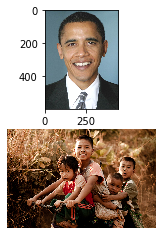

In [6]:
# quick overview of the pictures
plt_img = mpimg.imread(img_pth)
plt_img2 = mpimg.imread(img_pth_many)
plt.figure(1)
plt.subplot(211)
plt.imshow(plt_img)

plt.subplot(212)
plt.imshow(plt_img2)

plt.axis('off')
plt.show()


### pliers face detection

In [7]:
ext_pliers = FaceRecognitionFaceLocationsExtractor()
# for single face
result_pliers = ext_pliers.transform(stim).to_df()
# for many faces stimulus
result_pliers_many = ext_pliers.transform(stim_many).to_df()

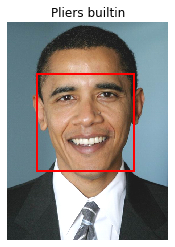

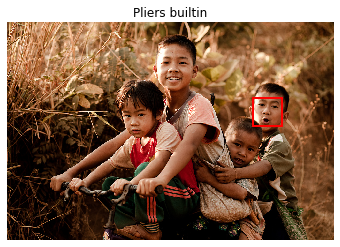

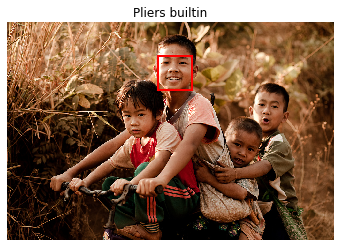

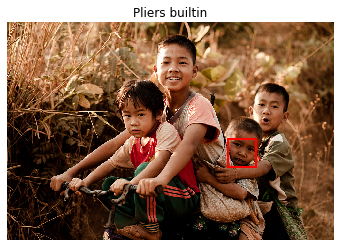

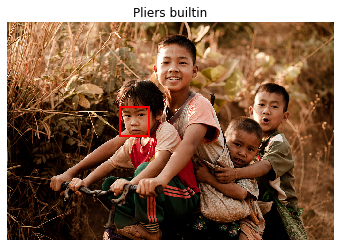

In [8]:
# extract faces for single and multi-face images from pliers-builtin, and plot them
for res, im, x_dim, y_dim in [(result_pliers, img_pth, x, y), (result_pliers_many, img_pth_many, x2, y2)]:
    d = extract_bounding(res, x=x_dim, y=y_dim)
    for k, i in d.items():
        top, right, bottom, left = i
        box_width = right-left
        box_height = top-bottom
        coords = [[left, bottom, box_width, box_height]]
        plot_boundingBox(im, coords, title='Pliers builtin')

### clarifai face detection

In [9]:
# the clarifai extraction needs a model and an api key
model='face' 
ext_clarifai = ClarifaiAPIImageExtractor(api_key='d53d5755b7514b87877df990f2d0bbd4',
                                         model=model)
result_clarifai = ext_clarifai.transform(stim).to_df()

# for many faces
result_clarifai_many = ext_clarifai.transform(stim_many).to_df()

In [ ]:
# transform relative coordinates into pixel
#top_row = y * result_clarifai['top_row'][0]
#bottom_row = y * result_clarifai['bottom_row'][0]
#left_col = x * result_clarifai['left_col'][0]
#right_col = x * result_clarifai['right_col'][0]
#print(top_row, right_col, bottom_row, left_col)

# Plot bounding on image 
#box_width = right_col - left_col
#box_height = top_row - bottom_row
#coords = [left_col, bottom_row, box_width, box_height]
#plot_boundingBox(img_pth, coords, 'Clarifai: wide face bounding box')

# fig,ax = plt.subplots(1)
# plt_img = mpimg.imread(img_pth)
# imgplot = ax.imshow(plt_img)


# #bottom left xy, width, height
# rect = patches.Rectangle((left_col,bottom_row),right_col-left_col,top_row-bottom_row,
#                          linewidth=2,
#                          edgecolor='r',
#                          facecolor='none',
#                         )

# #plt.scatter(0, top_row)

# # Add the patch to the Axes
# ax.add_patch(rect)
# plt.title('Pliers builtin: face bounding box')
# plt.show()

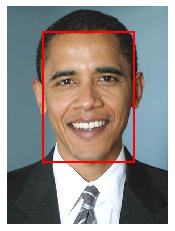

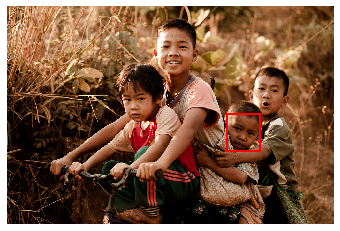

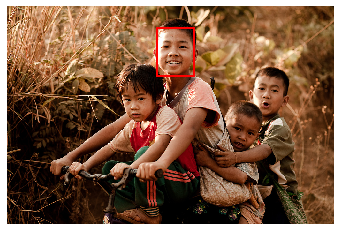

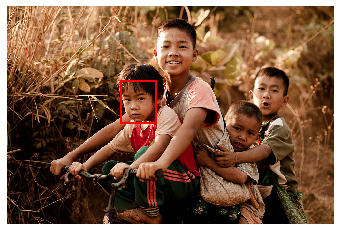

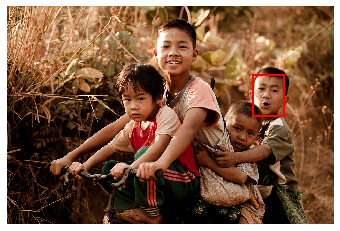

In [10]:
# extract faces for single and multi-face images from pliers-builtin, and plot them
for res, im, x_dim, y_dim in [(result_clarifai, img_pth, x, y), (result_clarifai_many, img_pth_many, x2, y2)]:
    d = extract_bounding(res, api='clarifai', x=x_dim, y=y_dim)
    for k, i in d.items():
        top, right, bottom, left = i
        box_width = right-left
        box_height = top-bottom
        coords = [[left, bottom, box_width, box_height]]
        plot_boundingBox(im, coords, 'Clarifai')

### Google Cloud vision API face detection

In [37]:
#ext_google = GoogleVisionAPIFaceExtractor(discovery_file='/home/adina/NeuroHackademy-02c15db15c2a.json')
ext_google = GoogleVisionAPIFaceExtractor(discovery_file='/Users/Mai/NeuroHackademy-02c15db15c2a.json')
#result_google = ext_google.transform(stim_many).to_df()
results_google = ext_google.transform(stim).to_df()
results_google

W0808 12:03:07.174238 140736167261056 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in

order  duration  onset  object_id  boundingPoly_vertex1_x  \
0    NaN       NaN    NaN          0                      34   

   boundingPoly_vertex1_y  boundingPoly_vertex2_x  boundingPoly_vertex2_y  \
0                       3                     413                       3   

   boundingPoly_vertex3_x  boundingPoly_vertex3_y  ...  tiltAngle  \
0                     413                     444  ...  -2.058331   

   face_detectionConfidence  face_landmarkingConfidence  joyLikelihood  \
0                  0.999946                     0.84057    VERY_LIKELY   

   sorrowLikelihood  angerLikelihood  surpriseLikelihood  \
0     VERY_UNLIKELY    VERY_UNLIKELY       VERY_UNLIKELY   

   underExposedLikelihood  blurredLikelihood  headwearLikelihood  
0           VERY_UNLIKELY      VERY_UNLIKELY       VERY_UNLIKELY  

[1 rows x 134 columns]

In [38]:
# Google has "wide" and "narrow" bounding boxes. Here we get the wide bounding box

#result_google.to_dict(orient='records')
# vertex coordinates are in the same scale as the original image.
# vertices are in order top-left, top-right, bottom-right, bottom-left.
top_left_x = results_google['boundingPoly_vertex1_x'][0]
top_right_x = results_google['boundingPoly_vertex2_x'][0]
bottom_right_x = results_google['boundingPoly_vertex3_x'][0]
bottom_left_x = results_google['boundingPoly_vertex4_x'][0]

top_left_y = results_google['boundingPoly_vertex1_y'][0]
top_right_y = results_google['boundingPoly_vertex2_y'][0]
bottom_right_y = results_google['boundingPoly_vertex3_y'][0]
bottom_left_y = results_google['boundingPoly_vertex4_y'][0]

print(top_left_x, top_right_x, bottom_right_x, bottom_left_x)
print(top_left_y, top_right_y, bottom_right_y, bottom_left_y)

34 413 413 34
3 3 444 444


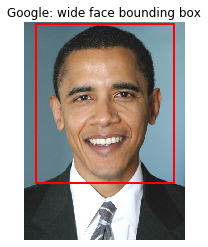

In [41]:
# # Plot bounding on image 
box_width = bottom_right_x - bottom_left_x
box_height =  bottom_right_y - top_right_y
coords_google_wide = [[bottom_left_x, top_left_y, box_width, box_height]]

plot_boundingBox(img_pth, coords_google_wide, title='Google: wide face bounding box')

In [43]:
# Google has "wide" and "narrow" bounding boxes. Here we get the narrow bounding box

# vertex coordinates are in the same scale as the original image.
# vertices are in order top-left, top-right, bottom-right, bottom-left.
top_left_x = results_google['fdBoundingPoly_vertex1_x'][0]
top_right_x = results_google['fdBoundingPoly_vertex2_x'][0]
bottom_right_x = results_google['fdBoundingPoly_vertex3_x'][0]
bottom_left_x = results_google['fdBoundingPoly_vertex4_x'][0]

top_left_y = results_google['fdBoundingPoly_vertex1_y'][0]
top_right_y = results_google['fdBoundingPoly_vertex2_y'][0]
bottom_right_y = results_google['fdBoundingPoly_vertex3_y'][0]
bottom_left_y = results_google['fdBoundingPoly_vertex4_y'][0]

print(top_left_x, top_right_x, bottom_right_x, bottom_left_x)
print(top_left_y, top_right_y, bottom_right_y, bottom_left_y)

81 367 367 81
112 112 397 397


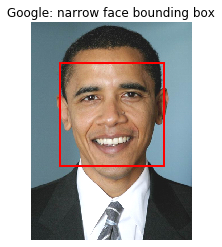

In [44]:

# Plot bounding on image 
box_width = bottom_right_x - bottom_left_x
box_height =  bottom_right_y - top_right_y
coords_google_narrow = [[bottom_left_x, top_left_y, box_width, box_height]]
plot_boundingBox(img_pth, coords_google_narrow, title = 'Google: narrow face bounding box')


### Compare different face bounding boxes

In [45]:
# let's start with looking at the coords
print('pliers: ' + str(coords_pliers))
print('clarifai: ' + str(coords_clarifai))
print('google (wide): ' + str(coords_google_wide))
print('google (narrow): ' + str(coords_google_narrow))

NameError: name 'coords_pliers' is not defined

In [ ]:
# Plot on the same figure

# Make a dictionary with coords
face_apis = ['pliers', 'clarifai', 'google_wide', 'google_narrow']
coord_dict = dict(zip(face_apis, [coords_pliers, coords_clarifai, coords_google_wide, coords_google_narrow]))


### Detect faces in a video

In [47]:
# Path to video
video_pth = opj('../', 'data', 'obama_speech.mp4')

# Sample 2 frames per second
sampler = FrameSamplingFilter(hertz=2)
frames = sampler.transform(video_pth)


In [48]:
# Extract using google API
ext_google = GoogleVisionAPIFaceExtractor(discovery_file='/Users/Mai/NeuroHackademy-02c15db15c2a.json')
results_google = ext_google.transform(frames)
results_google = merge_results(results_google, )


W0808 12:04:42.763099 140736167261056 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in

In [55]:
# get coordinates of the bounding box
# top_left_x = results_google['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex1_x']
# top_right_x = results_google['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex2_x']
# bottom_left_x = results_google['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex3_x']
# bottom_right_x = results_google['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex4_x']

# top_left_y = results_google['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex1_y']
# top_right_y = results_google['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex2_y']
# bottom_left_y = results_google['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex3_y']
# bottom_right_y = results_google['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex4_y']

results_google

class   stim_name  object_id  order  duration  \
0   VideoFrameStim    frame[0]          0    NaN      0.50   
1   VideoFrameStim    frame[0]          1    NaN      0.50   
2   VideoFrameStim    frame[6]          0    NaN      0.50   
3   VideoFrameStim    frame[6]          1    NaN      0.50   
4   VideoFrameStim   frame[12]          0    NaN      0.50   
5   VideoFrameStim   frame[12]          1    NaN      0.50   
6   VideoFrameStim   frame[18]          0    NaN      0.50   
7   VideoFrameStim   frame[18]          1    NaN      0.50   
8   VideoFrameStim   frame[24]          0    NaN      0.50   
9   VideoFrameStim   frame[24]          1    NaN      0.50   
10  VideoFrameStim   frame[30]          0    NaN      0.50   
11  VideoFrameStim   frame[30]          1    NaN      0.50   
12  VideoFrameStim   frame[36]          0    NaN      0.50   
13  VideoFrameStim   frame[36]          1    NaN      0.50   
14  VideoFrameStim   frame[42]          0    NaN      0.50   
15  VideoFrameStim   frame[42]          1    NaN      0.50   
16  VideoFrameStim   frame[48]          0    NaN      0.50   
17  VideoFrameStim   frame[48]          1    NaN      0.50   
18  VideoFrameStim   frame[54]          0    NaN      0.50   
19  VideoFrameStim   frame[54]          1    NaN      0.50   
20  VideoFrameStim   frame[60]          0    NaN      0.50   
21  VideoFrameStim   frame[60]          1    NaN      0.50   
22  VideoFrameStim   frame[66]          0    NaN      0.50   
23  VideoFrameStim   frame[66]          1    NaN      0.50   
24  VideoFrameStim   frame[72]          0    NaN      0.50   
25  VideoFrameStim   frame[72]          1    NaN      0.50   
26  VideoFrameStim   frame[78]          0    NaN      0.50   
27  VideoFrameStim   frame[78]          1    NaN      0.50   
28  VideoFrameStim   frame[84]          0    NaN      0.50   
29  VideoFrameStim   frame[84]          1    NaN      0.50   
30  VideoFrameStim   frame[90]          0    NaN      0.50   
31  VideoFrameStim   frame[90]          1    NaN      0.50   
32  VideoFrameStim   frame[96]          0    NaN      0.50   
33  VideoFrameStim   frame[96]          1    NaN      0.50   
34  VideoFrameStim  frame[102]          0    NaN      0.21   
35  VideoFrameStim  frame[102]          1    NaN      0.21   

                                              history  onset filename  \
0   VideoStim->FrameSamplingFilter/VideoFrameColle...    0.0      NaN   
1   VideoStim->FrameSamplingFilter/VideoFrameColle...    0.0      NaN   
2   VideoStim->FrameSamplingFilter/VideoFrameColle...    0.5      NaN   
3   VideoStim->FrameSamplingFilter/VideoFrameColle...    0.5      NaN   
4   VideoStim->FrameSamplingFilter/VideoFrameColle...    1.0      NaN   
5   VideoStim->FrameSamplingFilter/VideoFrameColle...    1.0      NaN   
6   VideoStim->FrameSamplingFilter/VideoFrameColle...    1.5      NaN   
7   VideoStim->FrameSamplingFilter/VideoFrameColle...    1.5      NaN   
8   VideoStim->FrameSamplingFilter/VideoFrameColle...    2.0      NaN   
9   VideoStim->FrameSamplingFilter/VideoFrameColle...    2.0      NaN   
10  VideoStim->FrameSamplingFilter/VideoFrameColle...    2.5      NaN   
11  VideoStim->FrameSamplingFilter/VideoFrameColle...    2.5      NaN   
12  VideoStim->FrameSamplingFilter/VideoFrameColle...    3.0      NaN   
13  VideoStim->FrameSamplingFilter/VideoFrameColle...    3.0      NaN   
14  VideoStim->FrameSamplingFilter/VideoFrameColle...    3.5      NaN   
15  VideoStim->FrameSamplingFilter/VideoFrameColle...    3.5      NaN   
16  VideoStim->FrameSamplingFilter/VideoFrameColle...    4.0      NaN   
17  VideoStim->FrameSamplingFilter/VideoFrameColle...    4.0      NaN   
18  VideoStim->FrameSamplingFilter/VideoFrameColle...    4.5      NaN   
19  VideoStim->FrameSamplingFilter/VideoFrameColle...    4.5      NaN   
20  VideoStim->FrameSamplingFilter/VideoFrameColle...    5.0      NaN   
21  VideoStim->FrameSamplingFilter/VideoFrameColle...    5.0      NaN   
22  VideoStim->FrameSamplingFilter/Vide

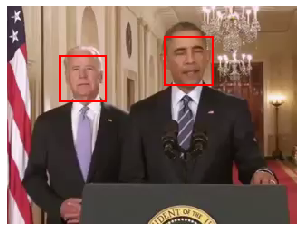

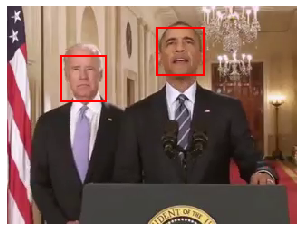

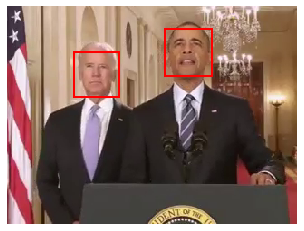

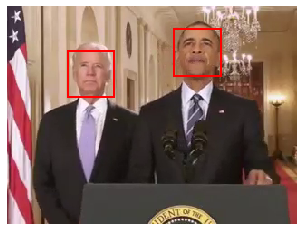

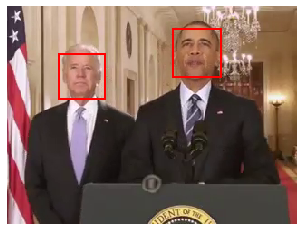

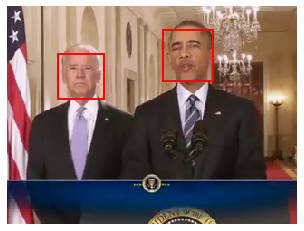

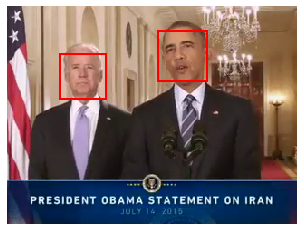

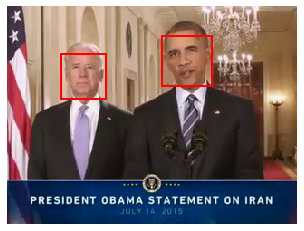

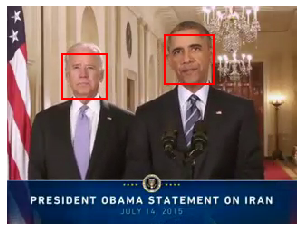

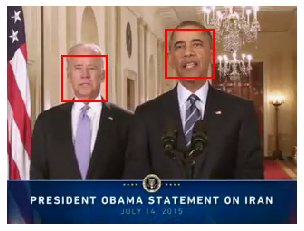

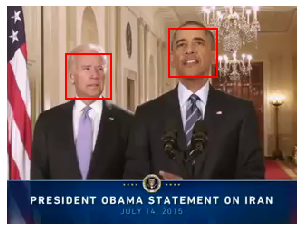

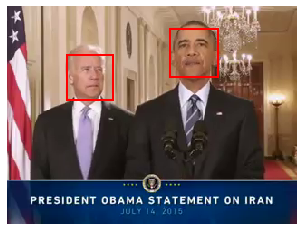

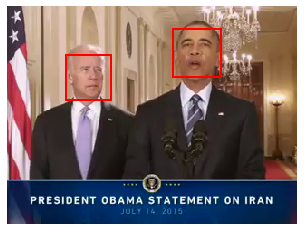

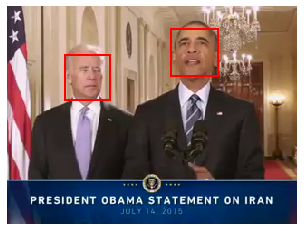

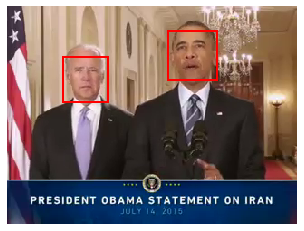

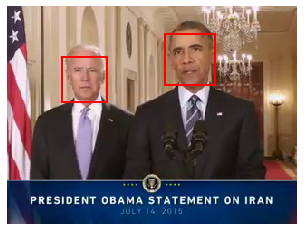

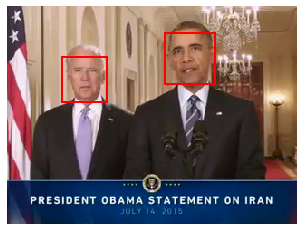

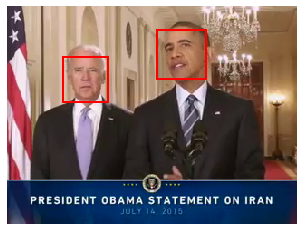

In [54]:
#for i in frames.n_frames:
out_dir = opj('../', 'output')

for i in range(frames.n_frames):
    # get this frame
    f = frames.get_frame(i)
    f_data = f.data
    f_name = f.name

    # get api output for this frame
    f_results_google = results_google.loc[results_google['stim_name'] == f_name]

    # get bounding box
    coords = []
    for index, row in f_results_google.iterrows():
        coords.append(get_faceBounds_google(row))

    # plot img with box and save    
    savename = opj(out_dir, 'img_' + str(i) + '.jpg')
    plot_boundingBox(f_data, coords, savename)



In [46]:
def get_faceBounds_google(df, boxtype='tight'):
    if boxtype is 'tight':    
        top_left_x = df['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex1_x']
        top_right_x = df['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex2_x']
        bottom_left_x = df['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex3_x']
        bottom_right_x = df['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex4_x']

        top_left_y = df['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex1_y']
        top_right_y = df['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex2_y']
        bottom_left_y = df['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex3_y']
        bottom_right_y = df['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex4_y']
        
    elif boxtype is 'wide':
        top_left_x = df['GoogleVisionAPIFaceExtractor#boundingPoly_vertex1_x']
        top_right_x = df['GoogleVisionAPIFaceExtractor#boundingPoly_vertex2_x']
        bottom_left_x = df['GoogleVisionAPIFaceExtractor#boundingPoly_vertex3_x']
        bottom_right_x = df['GoogleVisionAPIFaceExtractor#boundingPoly_vertex4_x']

        top_left_y = df['GoogleVisionAPIFaceExtractor#boundingPoly_vertex1_y']
        top_right_y = df['GoogleVisionAPIFaceExtractor#boundingPoly_vertex2_y']
        bottom_left_y = df['GoogleVisionAPIFaceExtractor#boundingPoly_vertex3_y']
        bottom_right_y = df['GoogleVisionAPIFaceExtractor#boundingPoly_vertex4_y']
    
    coords = [bottom_left_x, bottom_left_y, bottom_right_x - bottom_left_x, top_right_y - bottom_right_y]
    return coords